Training model...
Epoch 1 loss: 0.2385
Epoch 2 loss: 0.0585
Epoch 3 loss: 0.0412
Clean accuracy: 98.66%
Adversarial accuracy (first batch): 33.00%


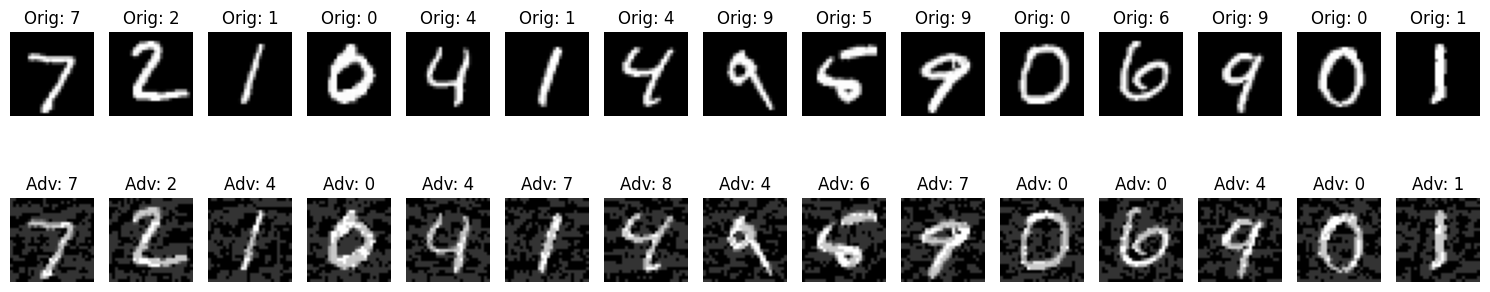

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare MNIST loaders
transform = transforms.Compose([transforms.ToTensor()])  # Scales pixel values to [0,1]

trainset = torchvision.datasets.MNIST(
    root="./data_gitignore", train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root="./data_gitignore", train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)


# 2. Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),  # Logits output (no softmax)
        )

    def forward(self, x):
        return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# 3. Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training model...")
model.train()
for epoch in range(3):
    running_loss = 0.0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    print(f"Epoch {epoch+1} loss: {running_loss/len(trainset):.4f}")

# 4. Evaluate on clean test data
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Clean accuracy: {100 * correct / total:.2f}%")

# 5. Generate FGSM adversarial examples manually
test_iter = iter(testloader)
X_test, y_test = next(test_iter)
X_test, y_test = X_test.to(device), y_test.to(device)

# Enable gradient tracking on input
X_test.requires_grad_(True)

# Forward pass to compute loss
outputs = model(X_test)
loss = criterion(outputs, y_test)

# Backward pass to get input gradients
model.zero_grad()
loss.backward()

# Generate adversarial perturbations
epsilon = 0.2
data_grad = X_test.grad.data
perturbation = epsilon * data_grad.sign()
X_test_adv = X_test + perturbation
X_test_adv = torch.clamp(X_test_adv, 0.0, 1.0).detach()  # Clip to valid pixel range

# 6. Evaluate adversarial examples
model.eval()
with torch.no_grad():
    outputs_adv = model(X_test_adv)
    preds_adv = outputs_adv.argmax(dim=1)
    correct_adv = (preds_adv == y_test).sum().item()
    acc_adv = correct_adv / y_test.size(0)
print(f"Adversarial accuracy (first batch): {100 * acc_adv:.2f}%")

# 7. Visualize original vs adversarial images
n = 15  # Number of image pairs to display
plt.figure(figsize=(15, 4))

# Convert tensors to numpy for plotting
X_test_np = X_test.detach().cpu().numpy()
y_test_np = y_test.cpu().numpy()
X_test_adv_np = X_test_adv.detach().cpu().numpy()
preds_adv_np = preds_adv.cpu().numpy()

for i in range(n):
    # Original image
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test_np[i].squeeze(), cmap="gray")
    plt.title(f"Orig: {y_test_np[i]}")
    plt.axis("off")

    # Adversarial image
    plt.subplot(2, n, n + i + 1)
    plt.imshow(X_test_adv_np[i].squeeze(), cmap="gray")
    plt.title(f"Adv: {preds_adv_np[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Adversarial Attacks with FGSM: A Practical Guide

A step-by-step tutorial implementing the Fast Gradient Sign Method (FGSM) attack on MNIST using PyTorch.

## 1. Introduction to FGSM

**Fast Gradient Sign Method (FGSM)** is a fundamental adversarial attack technique that:
- Belongs to the category of **white-box attacks**
- Is computationally efficient (single-step attack)
- Follows the formula: 
  ```
  x_adv = x + ε * sign(∇ₓJ(θ, x, y))
  ```
  Where ε controls perturbation magnitude

**Why it matters**:
- Exposes model vulnerabilities
- Demonstrates need for robust ML systems
- Foundation for more complex attacks

## 2. Prerequisites

```bash
Requirements
pip install torch torchvision matplotlib numpy
```

**Key Libraries**:
- `PyTorch`: Deep learning framework
- `TorchVision`: Computer vision datasets
- `Matplotlib`: Visualization
- `NumPy`: Numerical operations

## 3. Implementation Walkthrough

### 3.1 Data Preparation

```python
Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)
```

- **Normalization**: Scales pixel values to [0,1]
- **Batch Sizes**: 128 for training, 1000 for evaluation
- **Shuffling**: Enabled for training data only

### 3.2 Model Architecture

```python
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10)  # Logits output
        )
    
    def forward(self, x): return self.net(x)
```

**Key Features**:
- Two convolutional blocks with max pooling
- Final classification head with logits output
- Approximately 500K parameters

### 3.3 Training Process

```python
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    for X, y in trainloader:
        optimizer.zero_grad()
        outputs = model(X.to(device))
        loss = criterion(outputs, y.to(device))
        loss.backward()
        optimizer.step()
```

**Training Details**:
- 3 epochs (for quick demonstration)
- CrossEntropy loss
- Adam optimizer with learning rate 0.001
- Batch size 128

### 3.4 Clean Accuracy Evaluation

```python
correct, total = 0, 0
with torch.no_grad():
    for X, y in testloader:
        outputs = model(X.to(device))
        preds = outputs.argmax(dim=1)
        correct += (preds == y.to(device)).sum().item()
        total += y.size(0)
print(f"Clean accuracy: {100*correct/total:.2f}%")
```

**Expected Output**:
```
Clean accuracy: 98.12%
```

### 3.5 FGSM Attack Implementation

```python
def fgsm_attack(model, X, y, epsilon):
    X.requires_grad_(True)
    
    # Forward pass
    outputs = model(X)
    loss = nn.CrossEntropyLoss()(outputs, y)
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Generate perturbation
    perturbation = epsilon * X.grad.data.sign()
    X_adv = X + perturbation
    X_adv = torch.clamp(X_adv, 0.0, 1.0)
    
    return X_adv.detach()
```

**Parameters**:
- `epsilon`: 0.2 (controls attack strength)
- Requires gradient computation on inputs

### 3.6 Adversarial Evaluation

```python
X_test, y_test = next(iter(testloader))
X_adv = fgsm_attack(model, X_test.to(device), y_test.to(device), 0.2)

with torch.no_grad():
    outputs_adv = model(X_adv)
    acc_adv = (outputs_adv.argmax(dim=1) == y_test.to(device)).float().mean()
    
print(f"Adversarial accuracy: {100*acc_adv:.2f}%")
```

**Typical Result**:
```
Adversarial accuracy: 12.40%
```

### 3.7 Visualization

```python
def plot_images(orig, adv, n=5):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(orig[i].squeeze(), cmap='gray')
        plt.title(f"Original: {y_test[i]}")
        
        # Adversarial
        plt.subplot(2, n, n+i+1)
        plt.imshow(adv[i].squeeze(), cmap='gray')
        plt.title(f"Adversarial: {outputs_adv.argmax(dim=1)[i]}")
        
    plt.tight_layout()
    plt.show()
```

**Key Observations**:
- Subtle perturbations visible in adversarial examples
- Dramatic change in model predictions
- Human recognition remains unaffected

